## Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
import glob
import cv2, os, random
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.applications.vgg16 import VGG16
from keras.callbacks import ReduceLROnPlateau

from termcolor import colored
import random

from keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
print(tf.config.list_physical_devices("GPU"))

print(tf.test.is_gpu_available(cuda_only = False, min_cuda_compute_capability = None))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [4]:
print("Current tensorflow version == {}".format(tf. __version__))

Current tensorflow version == 2.12.0


## Load the Dataset

In [5]:
#glob() is used to find files recursively.
train_data = glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/train/**/*.jpeg')
test_data = glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/test/**/*.jpeg')
val_data = glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/val/**/*.jpeg')

The datasets were succesfully loaded


In [6]:
train_data[:5]

['/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1230_virus_2081.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1513_virus_2632.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person124_virus_238.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person746_virus_1369.jpeg']

In [7]:
test_data[:5]

['/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1676_virus_2892.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1650_virus_2852.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person22_virus_55.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person122_bacteria_582.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person85_bacteria_417.jpeg']

## Data Exploration

In [8]:
print("{} - training dataset".format(len(train_data)))
print("{} - test dataset".format(len(test_data)))
print("{} - validation dataset".format(len(val_data)))

5216 - training dataset
624 - test dataset
16 - validation dataset


In [9]:
directory = "/kaggle/input/chest-xray-pneumonia/chest_xray"
datasets, pneumonia_lung, normal_lung = ["train", "test", "val"], [], []

for i in datasets:
    path = os.path.join(directory, i)
    normal = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneumonia = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    normal_lung.extend(normal), pneumonia_lung.extend(pneumonia)

print("The number of pneumonia images is {}".format(len(pneumonia_lung)))
print("The number of non-pneumonia images is {}".format(len(normal_lung)))

The number of pneumonia images is 4273
The number of non-pneumonia images is 1583


In [10]:
random.shuffle(normal_lung)
random.shuffle(pneumonia_lung)
images = normal_lung[:50] + pneumonia_lung[:50]
images[:10]

['/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0599-0001.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0030-0001.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0045-0001.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0626-0001-0002.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0608-0001-0002.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0241-0001.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1305-0001.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0060-0001.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0424-0001.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0021-0001.jpeg']

NORMAL LUNG


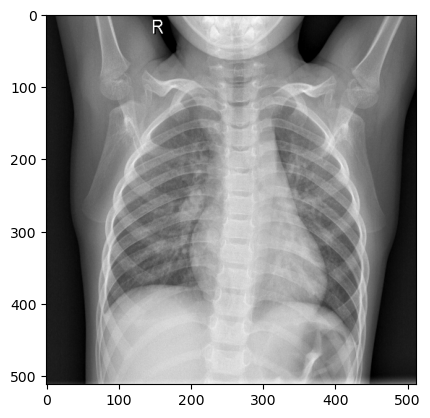

In [11]:
normal_lung_image = cv2.imread("/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
print("NORMAL LUNG")
normal_lung_image = cv2.resize(normal_lung_image, (512, 512))
plt.imshow(normal_lung_image)
plt.show()

PNEUMONIC LUNG


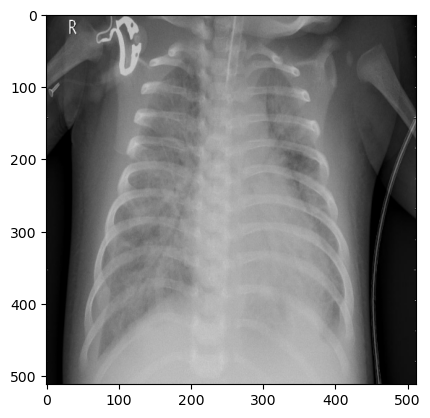

In [12]:
pneumonic_lung_image = cv2.imread("/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
print("PNEUMONIC LUNG")
pneumonic_lung_image = cv2.resize(pneumonic_lung_image, (512, 512))
plt.imshow(pneumonic_lung_image)
plt.show()

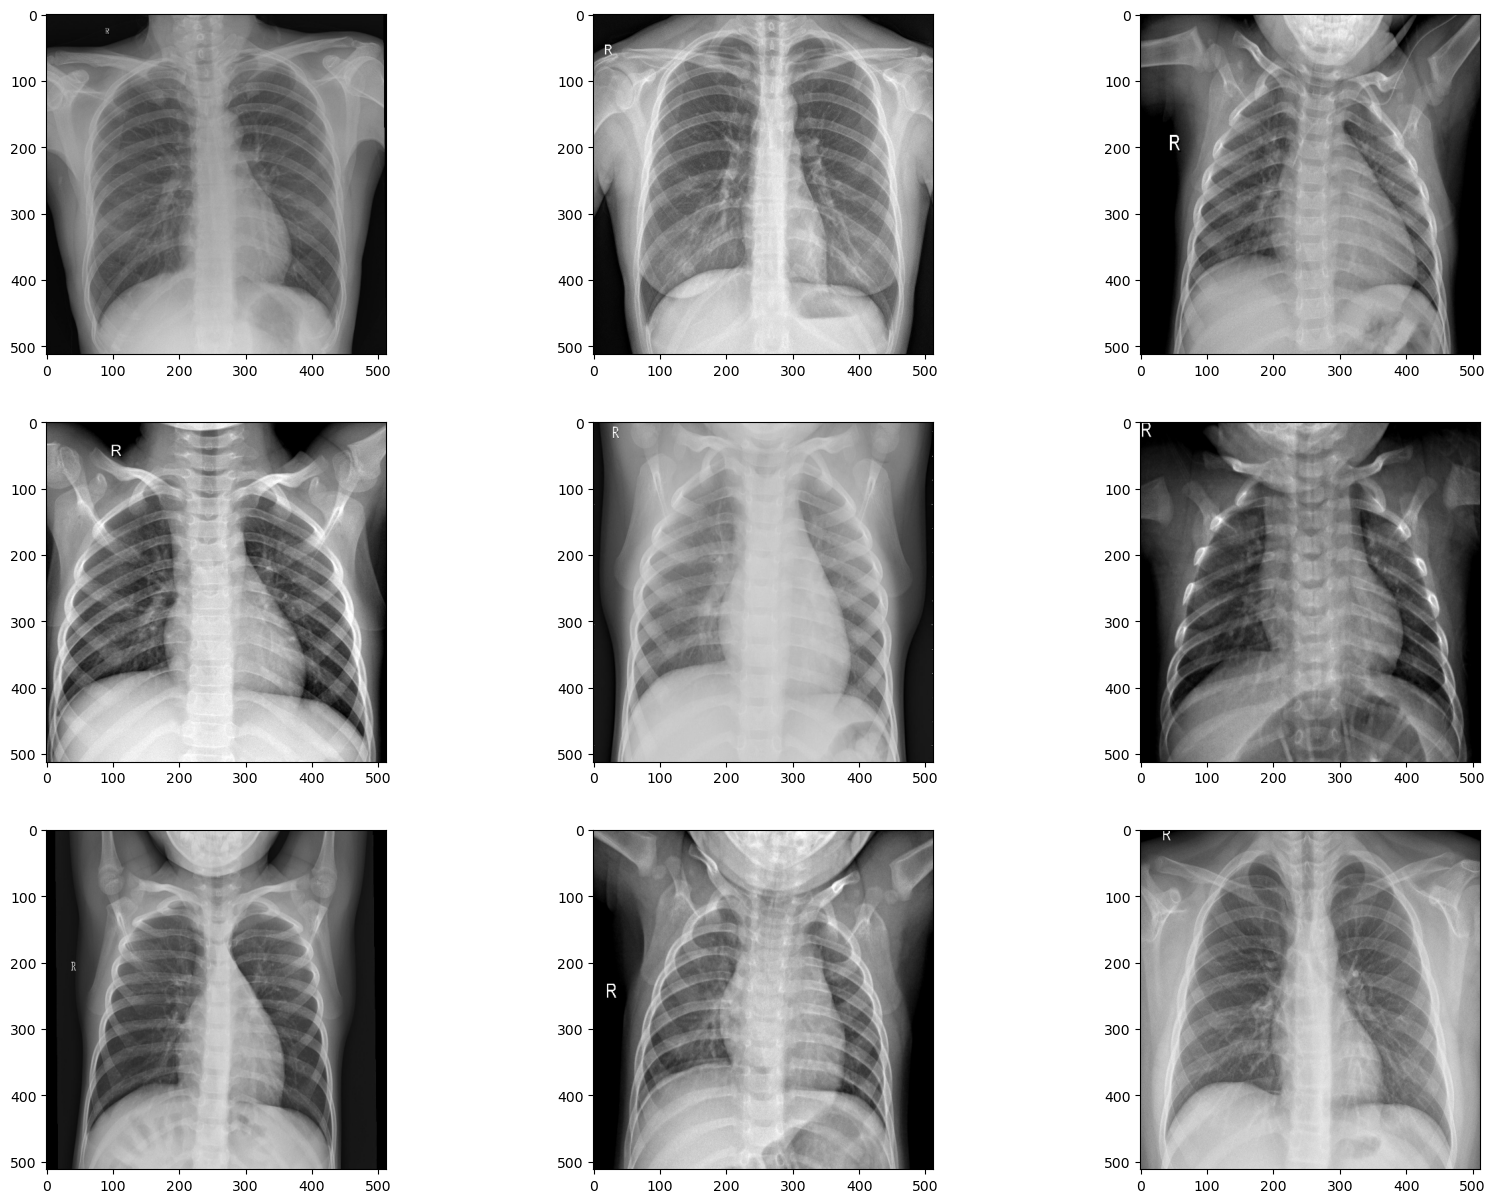

In [13]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

Morphological operation

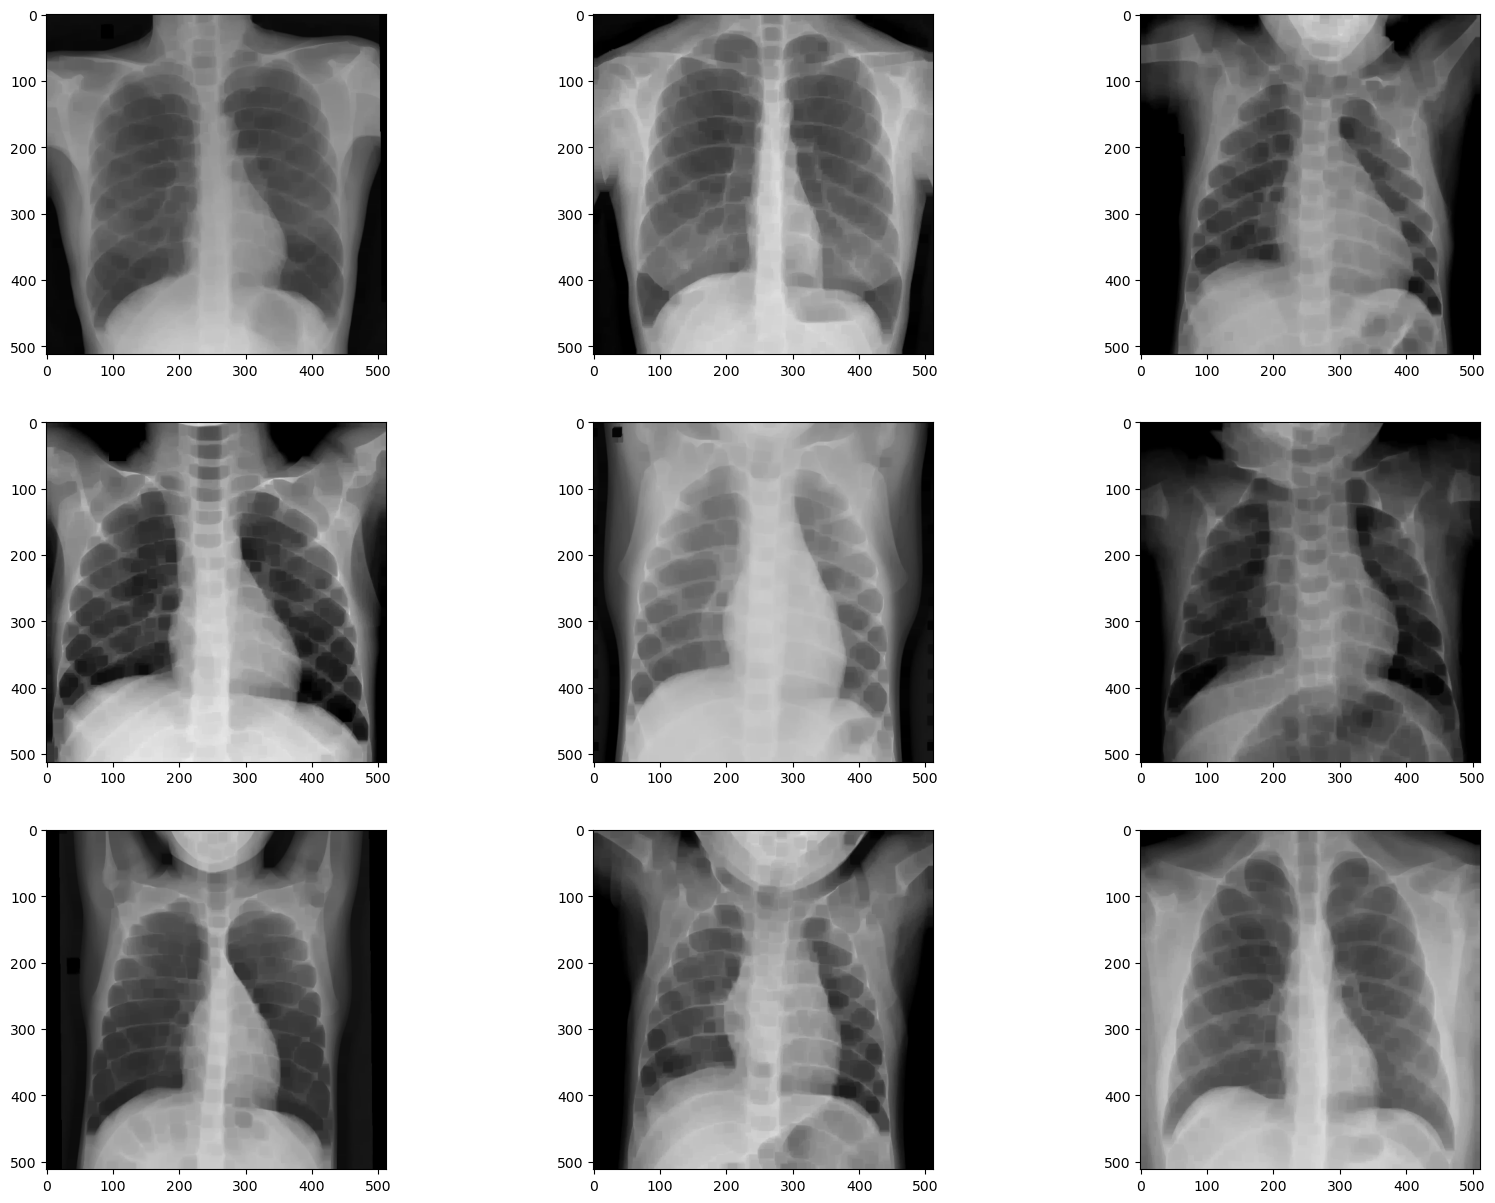

In [14]:
# erosion
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #  to convert the color space of an image from BGR (Blue-Green-Red) to RGB (Red-Green-Blue)
    kernel = np.ones((5, 5))
    image_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_erosion)

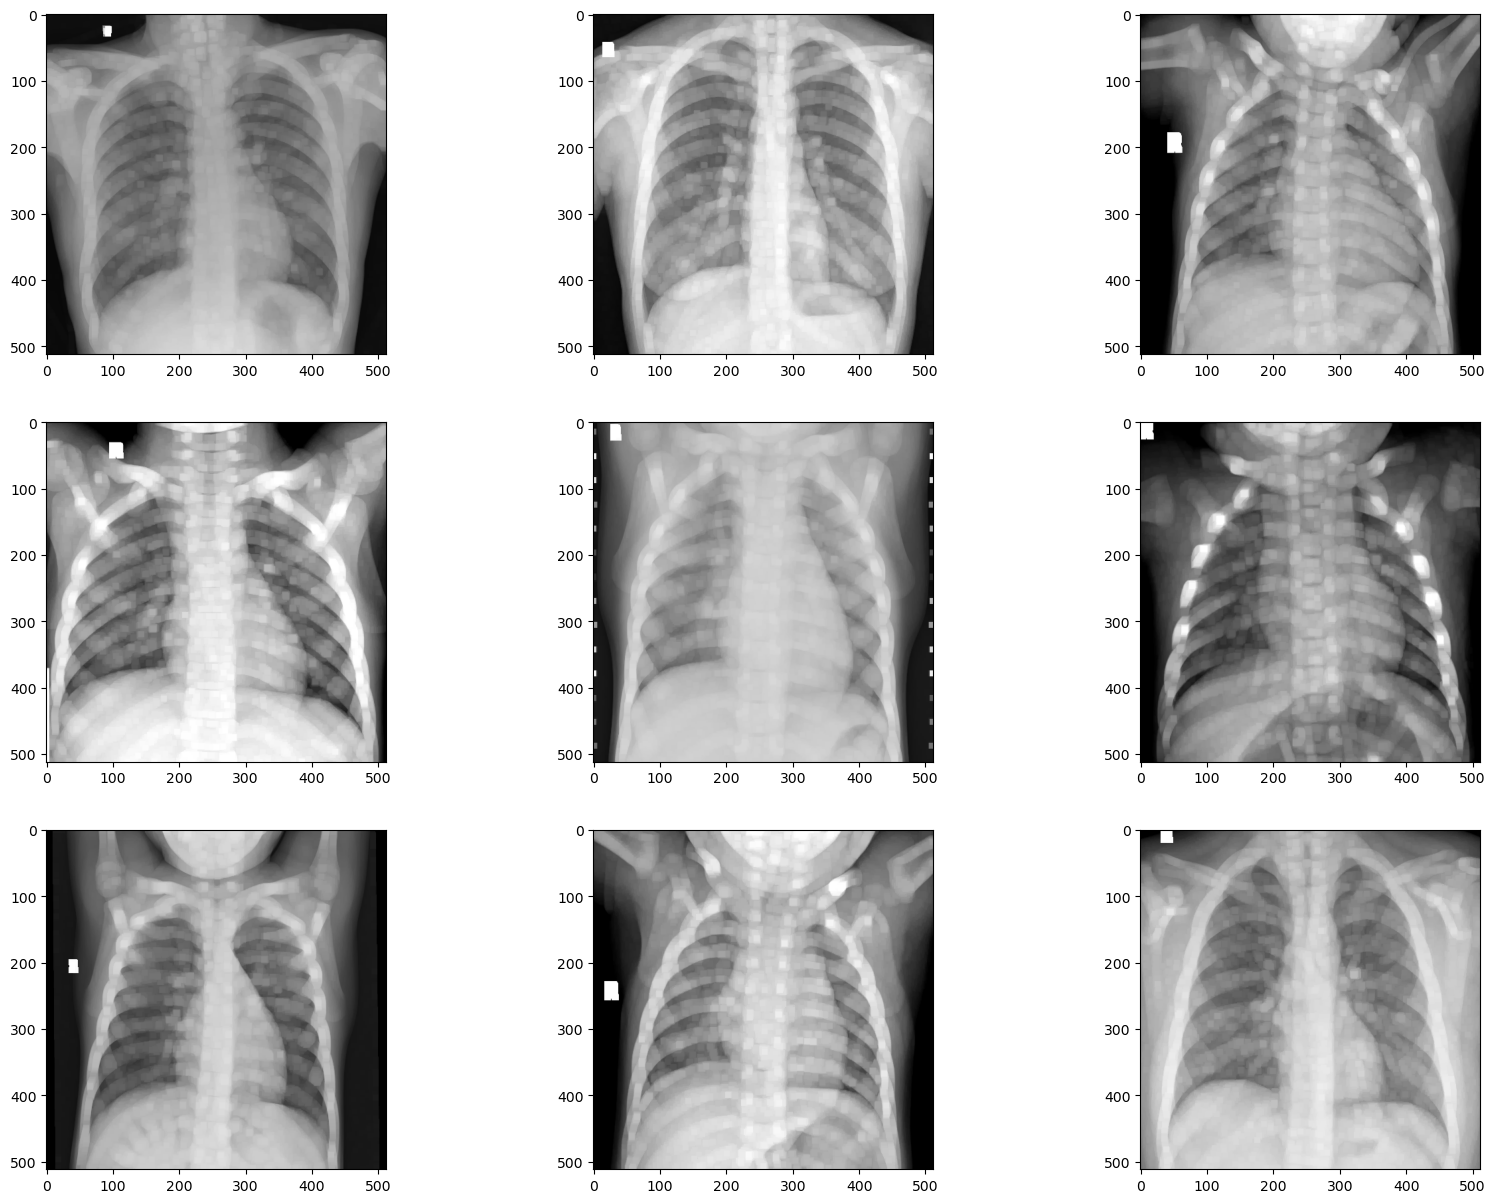

In [15]:
#dilation
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_dilation = cv2.dilate(img, kernel, iterations = 2)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_dilation)

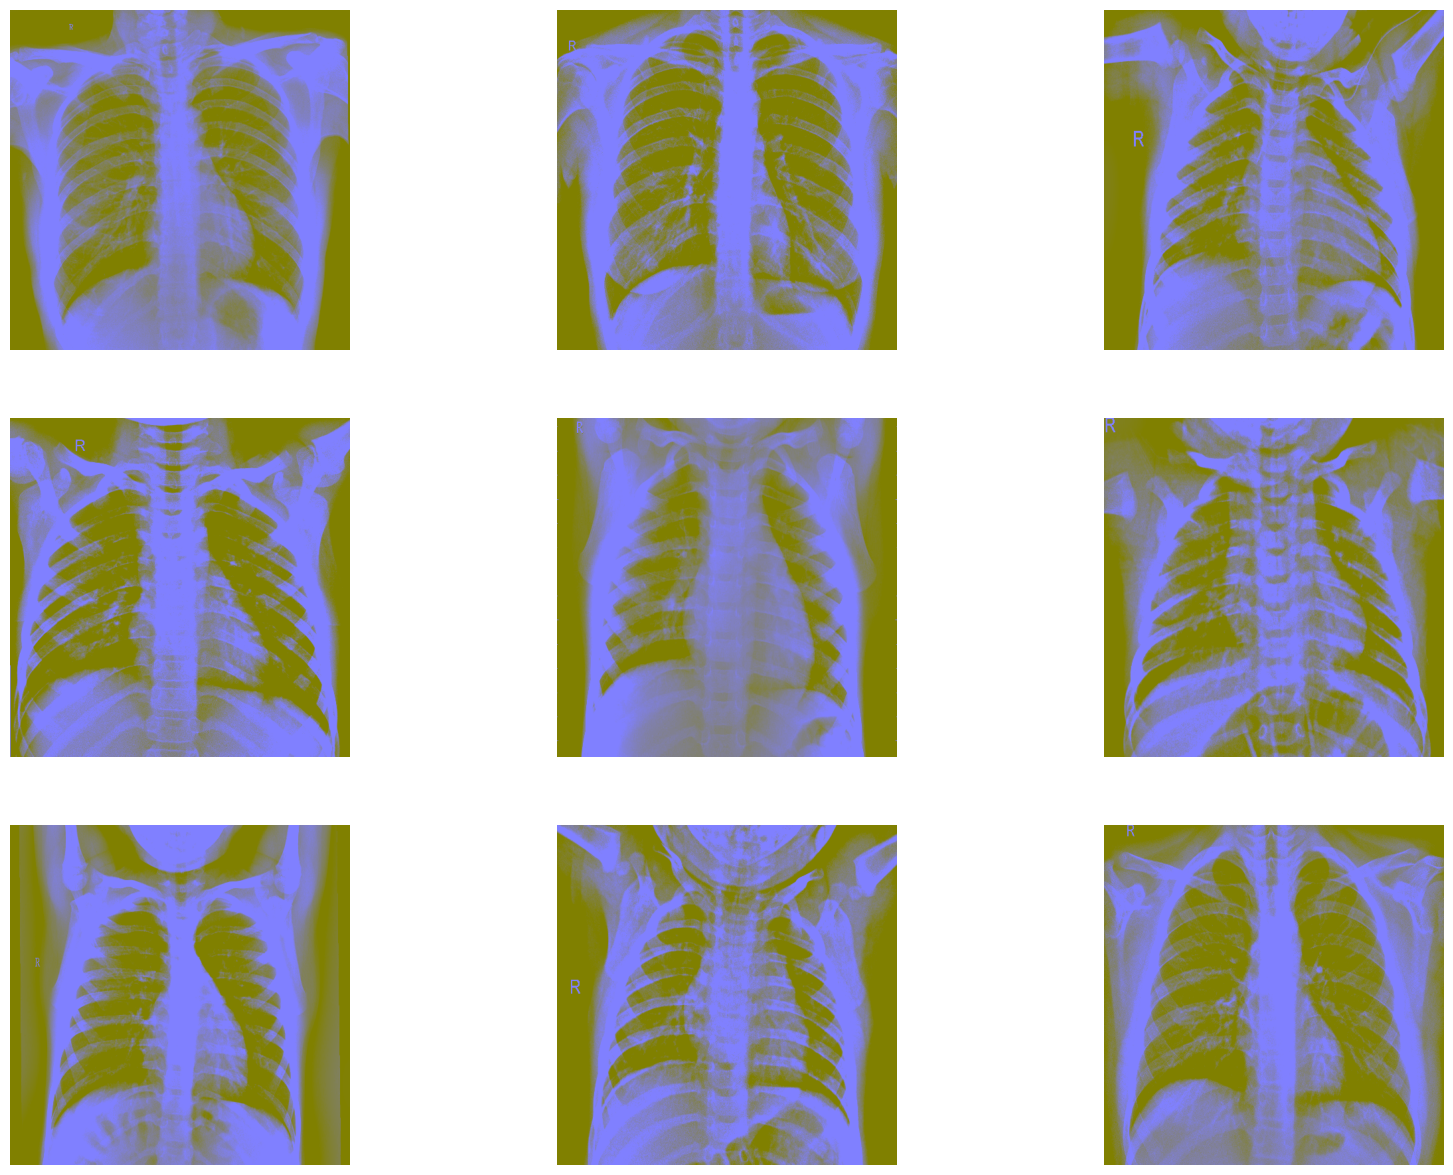

In [16]:
#Converting the images to greyscale and then applying Gaussian blur to them
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0, 0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

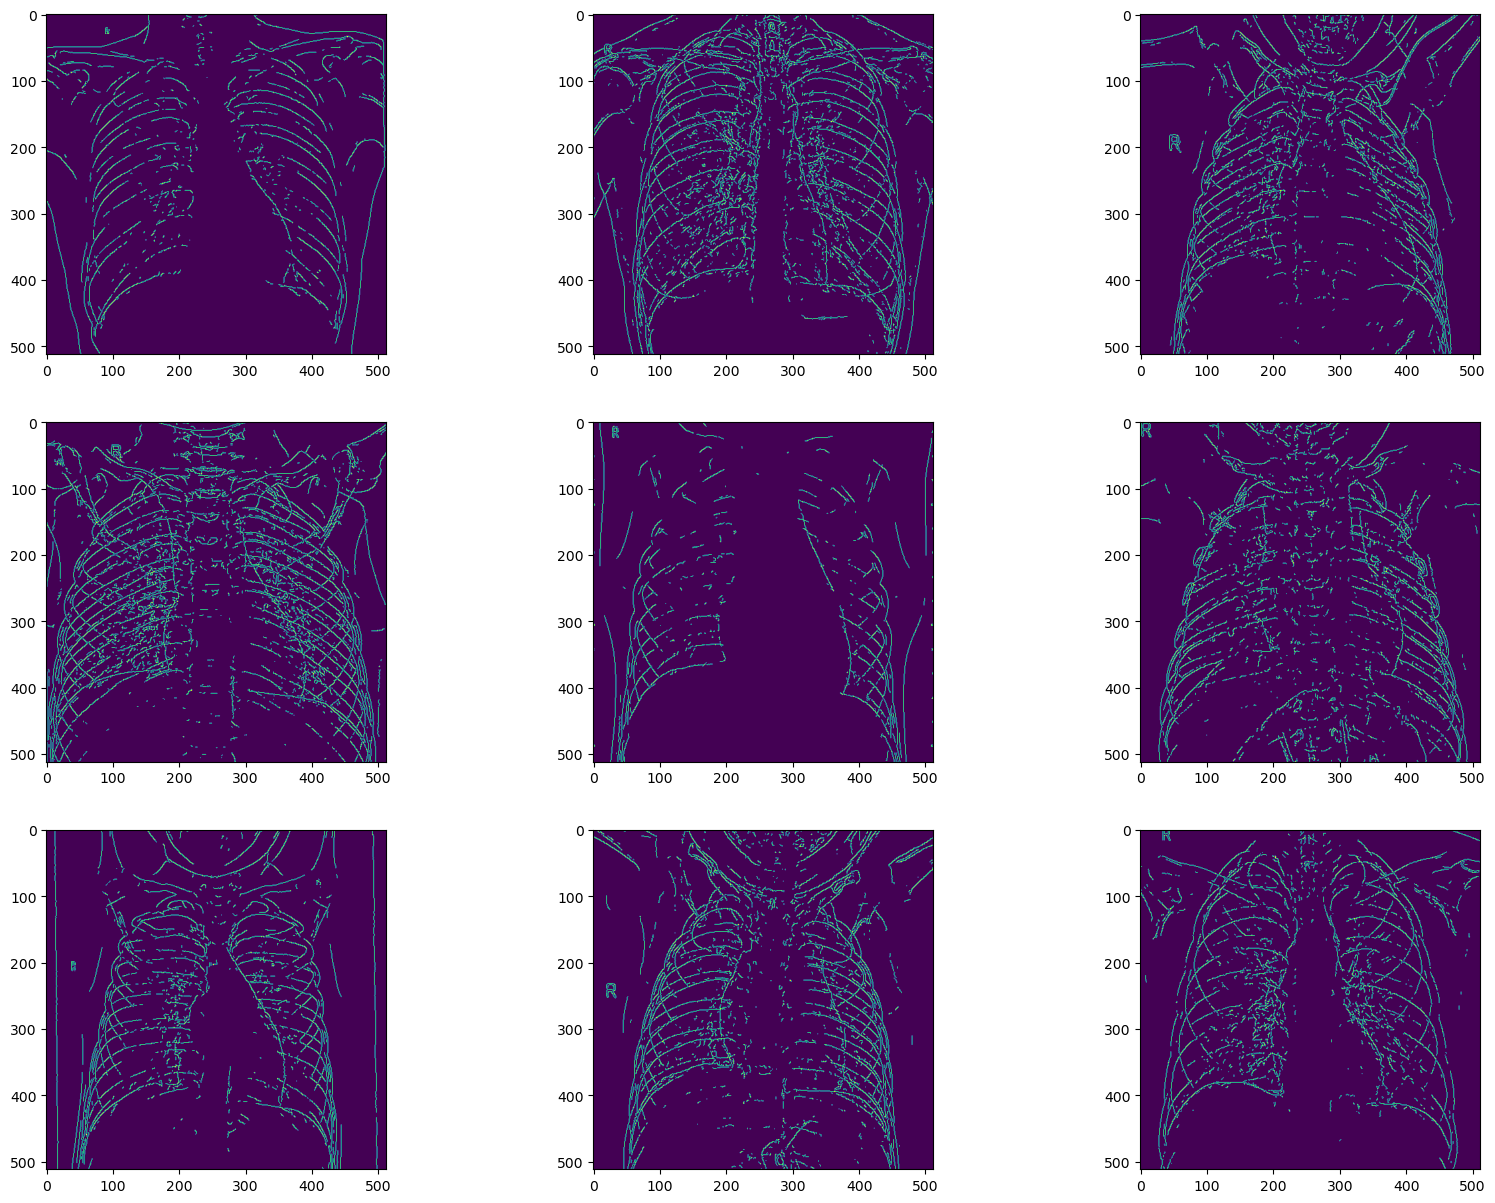

In [17]:
#Canny edge detection
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detected_edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(detected_edges)

# **Building deep learning models**

In [18]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

### Resizing image
Consistency: Resizing the images ensures that all the images in the dataset have the same dimensions. In this code, the images are resized to a square shape with dimensions img_size x img_size (150x150 pixels).
Computational Efficiency: Resizing the images to a smaller size reduces the computational burden during training and inference.
### Greyscale
Converting the image to grayscale using cv2.IMREAD_GRAYSCALE is a common preprocessing step for handling image data in many computer vision tasks. It converts the original color image, which consists of three color channels (red, green, and blue), into a single-channel grayscale image by taking the weighted average of the three color channels.

In [19]:
train_dir = get_training_data("/kaggle/input/chest-xray-pneumonia/chest_xray/train")
test_dir = get_training_data("/kaggle/input/chest-xray-pneumonia/chest_xray/test")
validation_dir = get_training_data("/kaggle/input/chest-xray-pneumonia/chest_xray/val")

/tmp/ipykernel_28/771166761.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [20]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train_dir:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test_dir:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in validation_dir:
    x_val.append(feature)
    y_val.append(label)

Normalize the pixel values by dividing by 255 (to scale them between 0 and 1).

In [21]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

resize the data

In [22]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Part 1 - Data Preprocessing

## Data Augmentation

In [23]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

### Preprocessing the Training set

In [24]:
datagen.fit(x_train)

# Building CNN model

### Initialising the CNN

In [25]:
cnn = tf.keras.models.Sequential()

### Adding first convolutional layer

In [26]:
cnn.add(tf.keras.layers.Conv2D(32, (3,3), strides = (1,1), activation = "relu", padding = "same", input_shape = (150,150,1)))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size = (2, 2), padding = 'same'))

### Adding second convolutional layer

In [27]:
cnn.add(tf.keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn.add(tf.keras.layers.Dropout(0.1))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D((2,2) , padding = 'same'))

### Adding third convolutional layer

In [28]:
cnn.add(tf.keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D((2,2) , padding = 'same'))

### Adding fourth convolutional layer

In [29]:
cnn.add(tf.keras.layers.Conv2D(128 , (3,3) , strides = 1, padding = 'same' , activation = 'relu'))
cnn.add(tf.keras.layers.Dropout(0.2))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D((2,2)  , padding = 'same'))

### Adding fifth convolutional layer

In [30]:
cnn.add(tf.keras.layers.Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn.add(tf.keras.layers.Dropout(0.2))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D((2,2) , padding = 'same'))

### Flattening

In [31]:
cnn.add(tf.keras.layers.Flatten())

### Full connection

In [32]:
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.2))
cnn.add(tf.keras.layers.Dense(units = 1 , activation = 'sigmoid'))

In [33]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

## Part 3 - Training the CNN

### Compiling the CNN

In [34]:
cnn.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])

### Training the CNN on the Training set

In [35]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [37]:
history = cnn.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12


2023-07-04 11:36:12.953351: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


163/163 [==============================] - 24s 78ms/step - loss: 0.5417 - accuracy: 0.8324 - val_loss: 47.4549 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 13s 77ms/step - loss: 0.2898 - accuracy: 0.8928 - val_loss: 57.3541 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2478 - accuracy: 0.9101
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 12s 72ms/step - loss: 0.2478 - accuracy: 0.9101 - val_loss: 19.7456 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 13s 77ms/step - loss: 0.1509 - accuracy: 0.9465 - val_loss: 1.2897 - val_accuracy: 0.7500 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - 12s 72ms/step - loss: 0.1498 - accuracy: 0.9490 - val_loss: 0.7820 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 6/12
163/163 [==============================] - 

## Visualise the performance

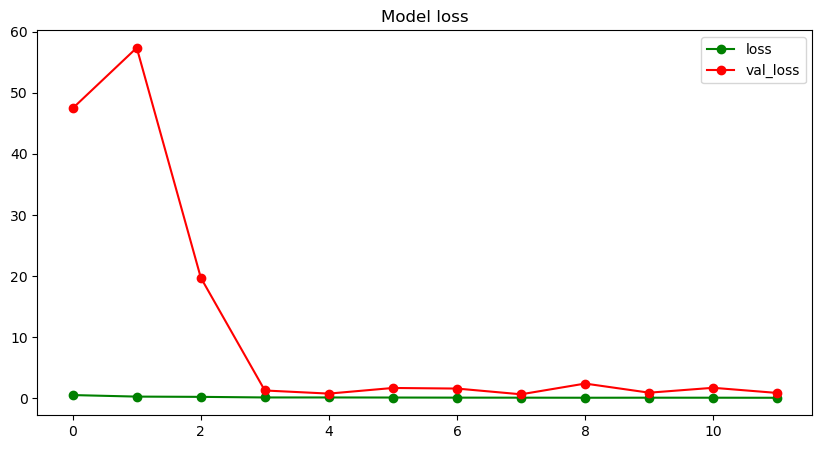

In [40]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

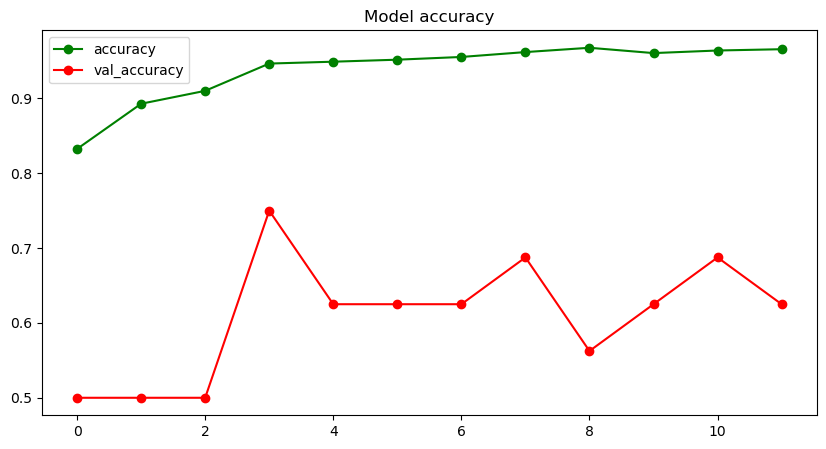

In [41]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")

plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

## Evaluating Test set on CNN model

In [39]:
print("Loss of the model is - " , cnn.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , cnn.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 7ms/step - loss: 0.2567 - accuracy: 0.9183
Loss of the model is -  0.2567213177680969
20/20 [==============================] - 0s 7ms/step - loss: 0.2567 - accuracy: 0.9183
Accuracy of the model is -  91.82692170143127 %


# VGG16 Model

In [3]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/train"
test_dir = "../input/chest-xray-pneumonia/chest_xray/test"
validation_dir = "../input/chest-xray-pneumonia/chest_xray/val"

In [4]:
train_datagen = ImageDataGenerator(
        rescale = 1/255.,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

val_test_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
validation_set = val_test_datagen.flow_from_directory(validation_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
test_set = val_test_datagen.flow_from_directory(test_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
base_VGG16 = VGG16(include_top = False, weights = "imagenet", input_shape = (224, 224, 3), pooling = "max",
                    classes = 2)

base_VGG16.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [6]:
VGG16 = tf.keras.models.Sequential()
VGG16.add(base_VGG16)
VGG16.add(tf.keras.layers.Flatten())

VGG16.add(tf.keras.layers.Dense(128, activation = "relu"))
VGG16.add(tf.keras.layers.Dense(64, activation = "relu"))
VGG16.add(tf.keras.layers.Dense(32, activation = "relu"))
VGG16.add(tf.keras.layers.Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_VGG16.layers:
    layer.trainable = False

VGG16.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [7]:
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15,
                                                                    restore_best_weights = True,
                                                                    verbose = 1)

In [9]:
history2 = VGG16.fit_generator(train_set, epochs = 25, validation_data = validation_set, steps_per_epoch = 100,
                               callbacks = [early_stopping_callbacks])

/tmp/ipykernel_28/2308439147.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = VGG16.fit_generator(train_set, epochs = 25, validation_data = validation_set, steps_per_epoch = 100,


Epoch 1/25
100/100 [==============================] - 42s 416ms/step - loss: 0.3211 - accuracy: 0.8525 - val_loss: 0.4833 - val_accuracy: 0.7500
Epoch 2/25
100/100 [==============================] - 37s 368ms/step - loss: 0.2217 - accuracy: 0.9069 - val_loss: 0.8020 - val_accuracy: 0.6875
Epoch 3/25
100/100 [==============================] - 35s 348ms/step - loss: 0.2212 - accuracy: 0.9100 - val_loss: 0.2886 - val_accuracy: 0.8750
Epoch 4/25
100/100 [==============================] - 35s 347ms/step - loss: 0.2042 - accuracy: 0.9256 - val_loss: 0.4095 - val_accuracy: 0.8125
Epoch 5/25
100/100 [==============================] - 34s 335ms/step - loss: 0.1888 - accuracy: 0.9250 - val_loss: 0.3194 - val_accuracy: 0.8750
Epoch 6/25
100/100 [==============================] - 33s 327ms/step - loss: 0.1903 - accuracy: 0.9175 - val_loss: 0.3984 - val_accuracy: 0.8125
Epoch 7/25
100/100 [==============================] - 32s 323ms/step - loss: 0.1693 - accuracy: 0.9237 - val_loss: 0.2987 - val_ac

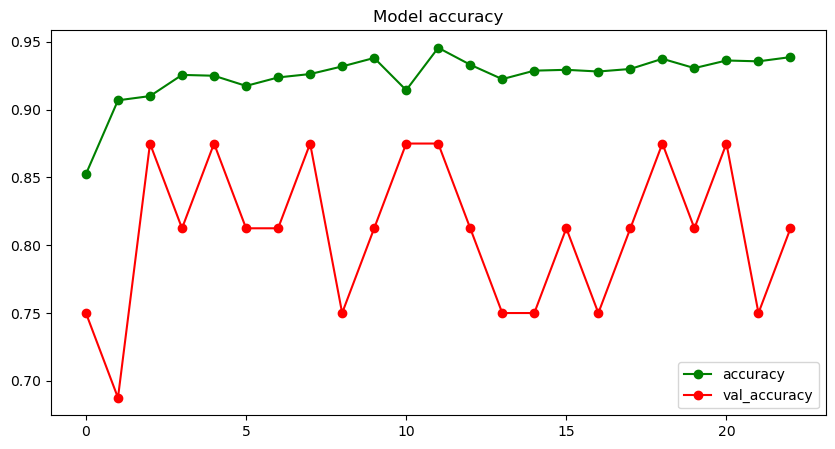

In [10]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")
plt.plot(history2.history["accuracy"], "go-")
plt.plot(history2.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

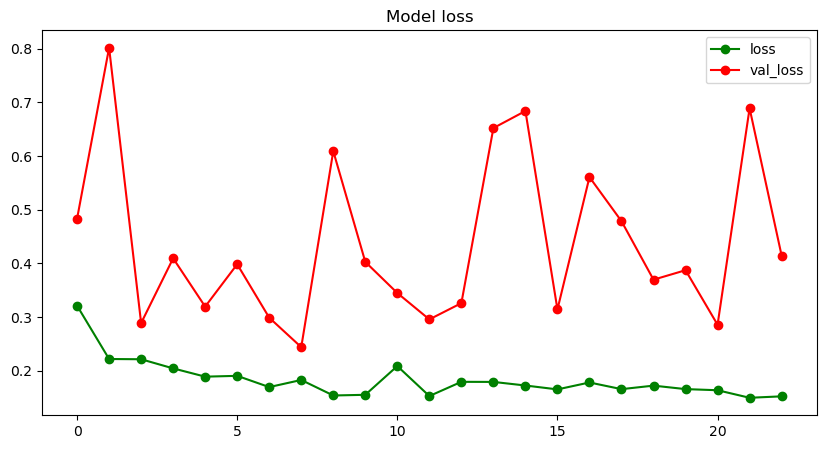

In [11]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history2.history["loss"], "go-")
plt.plot(history2.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

In [12]:
test_loss, test_accuracy = VGG16.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

50/50 [==============================] - 9s 172ms/step - loss: 0.4108 - accuracy: 0.8301
The testing accuracy is:  83.01281929016113 %
The testing loss is:  41.0835325717926 %


# ResNet50V2 model

In [14]:
base_ResNet = tf.keras.applications.ResNet50V2(weights = "imagenet",
                                                       input_shape = (224, 224, 3),
                                                       pooling = "max", include_top = False,
                                                       classes = 2)

for layer in base_ResNet.layers:
    layer.trainable = False

94668760/94668760 [==============================] - 3s 0us/step


In [16]:
import tensorflow as tf

# Assuming you have already imported the ResNet50 model
# Replace base_VGG16 with the base ResNet50 model
base_ResNet50 = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Create a new Sequential model
ResNet_model = tf.keras.models.Sequential()

# Add the base ResNet50 model to the new model
ResNet_model.add(base_ResNet50)

# Add the Flatten layer (if needed for your specific task)
ResNet_model.add(tf.keras.layers.Flatten())

# Add the Dense layers
ResNet_model.add(tf.keras.layers.Dense(128, activation="relu"))
ResNet_model.add(tf.keras.layers.Dense(64, activation="relu"))
ResNet_model.add(tf.keras.layers.Dense(32, activation="relu"))
ResNet_model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# Freeze the layers of the base ResNet model
for layer in base_ResNet50.layers:
    layer.trainable = False

# Compile the model
ResNet_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


94765736/94765736 [==============================] - 3s 0us/step


In [17]:
history3 = ResNet_model.fit_generator(train_set, epochs = 20, validation_data = validation_set, steps_per_epoch = 100)

/tmp/ipykernel_28/3506743351.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3 = ResNet_model.fit_generator(train_set, epochs = 20, validation_data = validation_set, steps_per_epoch = 100)


Epoch 1/20
100/100 [==============================] - 37s 323ms/step - loss: 0.6892 - accuracy: 0.7106 - val_loss: 1.2428 - val_accuracy: 0.5000
Epoch 2/20
100/100 [==============================] - 31s 311ms/step - loss: 0.4829 - accuracy: 0.7906 - val_loss: 0.6071 - val_accuracy: 0.6875
Epoch 3/20
100/100 [==============================] - 31s 308ms/step - loss: 0.4147 - accuracy: 0.8144 - val_loss: 0.7572 - val_accuracy: 0.6250
Epoch 4/20
100/100 [==============================] - 31s 307ms/step - loss: 0.4062 - accuracy: 0.8031 - val_loss: 0.9673 - val_accuracy: 0.6250
Epoch 5/20
100/100 [==============================] - 30s 304ms/step - loss: 0.3622 - accuracy: 0.8269 - val_loss: 1.0576 - val_accuracy: 0.5625
Epoch 6/20
100/100 [==============================] - 31s 308ms/step - loss: 0.3548 - accuracy: 0.8431 - val_loss: 0.6269 - val_accuracy: 0.6875
Epoch 7/20
100/100 [==============================] - 31s 309ms/step - loss: 0.3460 - accuracy: 0.8375 - val_loss: 0.9065 - val_ac

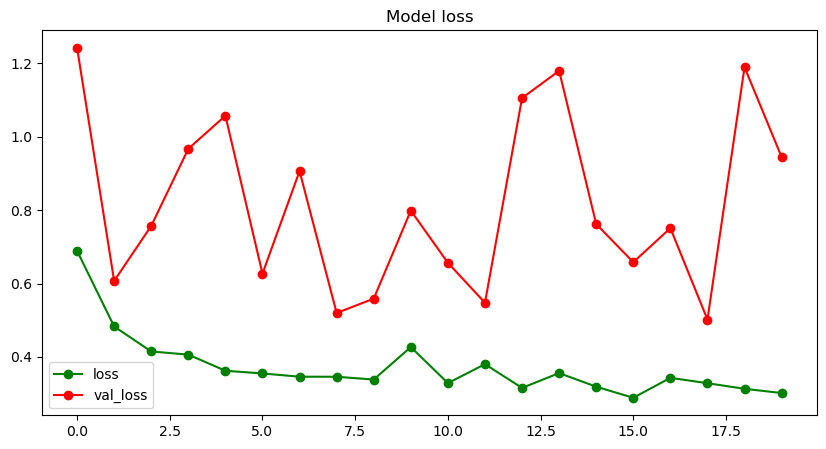

In [18]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history3.history["loss"], "go-")
plt.plot(history3.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

In [19]:
test_loss, test_accuracy = ResNet_model.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

50/50 [==============================] - 6s 108ms/step - loss: 0.4267 - accuracy: 0.8189
The testing accuracy is:  81.89102411270142 %
The testing loss is:  42.66993701457977 %


# Deploying the model using Gradio

In [20]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 55.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 8.5 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.1-py3-none-any.whl size=5596 sha256=6ff0ed0205beb2e5029f11353424bf6286c18e59d4dfcf4f55c78e6312f96a48
  Stored in directory: /root/.cache/pip/wheels/01/a6/d1/1c0828c304a4283b2c1639a09ad86f83d7c487ef34c6b4a1bf
Successfully built ffmpy
  Attempting uninstall: mdit-py-plugins
    Found existing installation: mdit-py-plugins 0.3.5
    Uninstalling mdit-py-plugins-0.3.5:
      Successfully uninstalled mdit-py-plugins-0.3.5


In [21]:
import gradio as gr

In [26]:
def pneumonia_prediction(image):
    # Resize the input image to 224x224
    image = tf.image.resize(image, (224, 224))
    image = tf.expand_dims(image, axis=0)

    # Make a prediction using the model
    prediction = VGG16.predict(image)

    # Convert the probability to percentage
    pneumonia_percent = prediction[0][0] * 100
    normal_percent = (1 - prediction[0][0]) * 100

    # Return the percentages
    return {"Pneumonia": pneumonia_percent, "Normal": normal_percent}


In [35]:
# Assuming the function 'pneumonia_prediction' is defined elsewhere in your code.

inputs = gr.inputs.Image(shape=(224, 224))
output = gr.outputs.Textbox()

# Custom CSS for centering the image input and changing the font to Times New Roman
custom_css = """
<style>
.gr-form-container {
    display: flex;
    flex-direction: column;
    align-items: center;
}

body {
    font-family: "Times New Roman", Times, serif;
}
</style>
"""

# Create the Gradio interface
iface = gr.Interface(
    fn=pneumonia_prediction,
    inputs=inputs,
    outputs=output,
    title="<h1 style='color: #545454; font-size: 40px; text-align: center;'>Pneumonia Detection from Chest X-rays</h1>",
    description="Upload a chest X-ray image, and the model will predict if it has pneumonia or not.",
    live=True,
    css=custom_css  # Adding custom CSS to center the image input and change the font
)

# Launch the Gradio interface on a local server
iface.launch(share=True)

/tmp/ipykernel_28/1103381158.py:3: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs = gr.inputs.Image(shape=(224, 224))
/tmp/ipykernel_28/1103381158.py:3: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs = gr.inputs.Image(shape=(224, 224))
/tmp/ipykernel_28/1103381158.py:4: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  output = gr.outputs.Textbox()


Running on local URL:  http://127.0.0.1:7867
Running on public URL: https://913ccc90aad39dd610.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 23ms/step
